In [1]:
import numpy as np
import sklearn
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
SIZE = 28
meta = pd.read_csv('metadata.csv', delimiter=',')
data = np.loadtxt(f'hmnist_{SIZE}_{SIZE}_L.csv', delimiter=',', skiprows=1, usecols=range(SIZE * SIZE))


In [3]:
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

smote = SMOTE(k_neighbors = 5)
X, y = smote.fit_resample(data, meta.dx)

X_train, X_test, y_train, y_test = train_test_split(X, to_categorical(label_encoder.fit_transform(y)), test_size=0.2)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.25)

2023-03-01 21:24:02.127562: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-01 21:24:02.651046: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/vande/miniconda3/envs/tf/lib/
2023-03-01 21:24:02.652275: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/vande/miniconda3/envs/tf/lib/
2023-03-01 21:24:02.652281: W tensorflow/compiler/tf2ten

In [4]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=60) # reduce to 60 dimensions
# pca.fit(X_train)

# X_train = pca.transform(X_train)
# X_test = pca.transform(X_test)
# X_validate = pca.transform(X_validate)

In [5]:
X_tr = np.array(X_train).reshape(len(X_train), SIZE, SIZE)
X_test = np.array(X_test).reshape(len(X_test), SIZE, SIZE)
X_validate = np.array(X_validate).reshape(len(X_validate), SIZE, SIZE)


X_tr = X_tr[:, :, :, None]
X_test = X_test[:, :, :, None]
X_validate = X_validate[:, :, :, None]

In [6]:
import keras
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25)) # Dropout 25% of the nodes of the previous layer during training
model.add(Flatten())     # Flatten, and add a fully connected layer
model.add(Dense(128, activation='relu')) 
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax')) # Last layer: 10 class nodes, with dropout
model.summary()

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_tr, y_train, epochs=20, batch_size=64, validation_data=(X_validate, y_validate))

2023-03-01 21:24:04.155694: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 32)        0         
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 128)               589952    
                                                        

2023-03-01 21:24:04.168961: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-01 21:24:04.169057: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-01 21:24:04.169586: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-01 21:24:04.170909: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_nod

Epoch 1/20


2023-03-01 21:24:06.748814: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-03-01 21:24:07.452478: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-01 21:24:08.264703: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2023-03-01 21:24:08.264731: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:237] Used ptxas at ptxas
2023-03-01 21:24:08.264773: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-03-01 21:24:09.

441/441 [==============================] - 8s 9ms/step - loss: 2.4041 - accuracy: 0.2197 - val_loss: 1.6489 - val_accuracy: 0.3130
Epoch 2/20
441/441 [==============================] - 3s 8ms/step - loss: 1.6683 - accuracy: 0.3173 - val_loss: 1.4641 - val_accuracy: 0.4092
Epoch 3/20
441/441 [==============================] - 3s 8ms/step - loss: 1.4811 - accuracy: 0.4106 - val_loss: 1.4482 - val_accuracy: 0.4496
Epoch 4/20
441/441 [==============================] - 3s 8ms/step - loss: 1.3351 - accuracy: 0.4787 - val_loss: 1.3256 - val_accuracy: 0.4848
Epoch 5/20
441/441 [==============================] - 4s 8ms/step - loss: 1.2488 - accuracy: 0.5209 - val_loss: 1.1339 - val_accuracy: 0.5719
Epoch 6/20
441/441 [==============================] - 4s 9ms/step - loss: 0.9877 - accuracy: 0.6235 - val_loss: 0.6787 - val_accuracy: 0.7599
Epoch 7/20
441/441 [==============================] - 3s 8ms/step - loss: 0.8084 - accuracy: 0.6881 - val_loss: 0.5272 - val_accuracy: 0.8134
Epoch 8/20
441/44

In [7]:
def plot_model_history(model_history):
    print(model_history.history.keys)
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    # axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])//10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    # axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

294/294 [==============================] - 1s 5ms/step - loss: 0.2102 - accuracy: 0.9313
Validation: accuracy = 0.931288  ;  loss_v = 0.210214
<built-in method keys of dict object at 0x7f23fd394480>


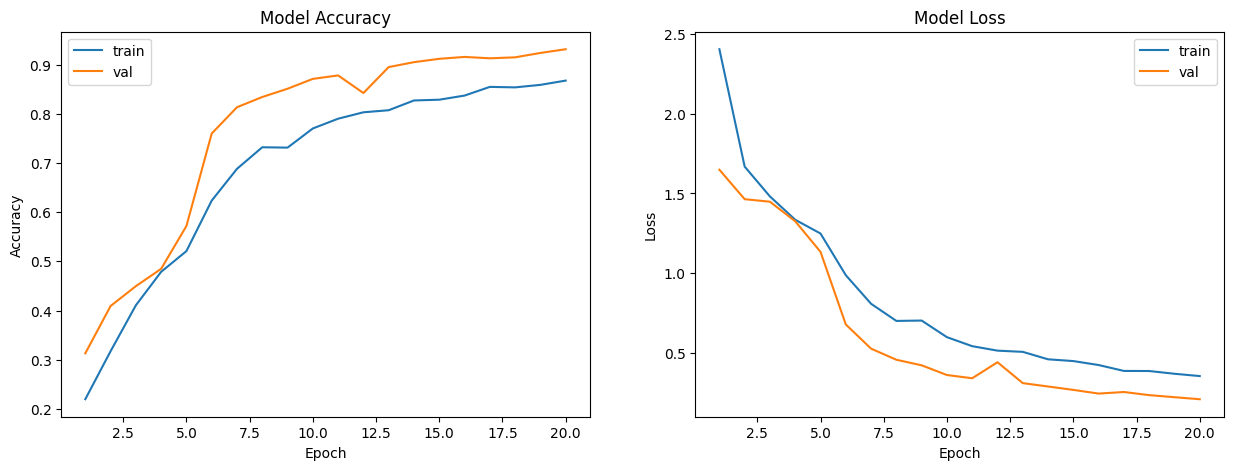

In [12]:
# test = model.evaluate(X_test, y_test)
# loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(X_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
# print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

plot_model_history(history)

In [9]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

294/294 [==============================] - 1s 2ms/step
(9387, 7)


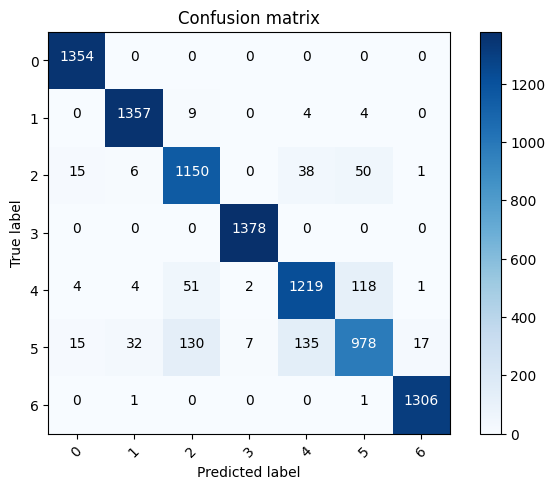

In [10]:
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_validate)
print(Y_pred.shape)
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
Y_true = np.argmax(y_validate, axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes = range(7)) 